In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

from matplotlib.ticker import FormatStrFormatter

import scipy.stats as sstat
import scipy.signal as ssig
import h5py
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
import re

# import ephys_unit_analysis as ena
import mz_ephys_unit_analysis as mz_ena

#import resampy
import fnmatch
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

sns.despine()

<Figure size 432x288 with 0 Axes>

In [3]:
# for publication quality plots
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
        'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
        'axes.linewidth':2.5, 'lines.linewidth': 2.5,
        'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black',
        'axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

set_pub_plots()

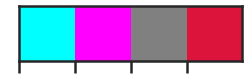

In [4]:
pal=sns.blend_palette(['cyan','magenta','grey','crimson'], 4)
sns.palplot(pal)
sns.set_palette(pal)

---

In [5]:
def vis_resp_units(final_df, time_window=[0.5, 0.7], z_score=2):
        
    vis_resp = final_df[(final_df['times'] >= time_window[0]) 
                       & (final_df['times'] <= time_window[1]) 
                       & (final_df['zscore'] > z_score)]
    
    test2 = final_df[final_df.cuid.isin(vis_resp.cuid.unique())]
    
    return test2
    

# First, load in the previously saved dataFrame

In [6]:
prepost_df = pd.read_pickle(r"D:\mz_Data\saved_dfs\Multi_brain_regions\V1Hip_psth.pkl")
novel_df = pd.read_pickle(r"D:\mz_Data\saved_dfs\Multi_brain_regions\V1Hip_novel_psth.pkl")
post2_df = pd.read_pickle(r"D:\mz_Data\saved_dfs\Multi_brain_regions\post2_psth.pkl")

print(prepost_df.columns)
print(prepost_df.columns)
print(post2_df.columns)

Index(['times', 'cuid', 'depth', 'Hz', 'zscore', 'ztc', 'region', 'stim',
       'group', 'cc', 'et', 'cluster_id', 'path'],
      dtype='object')
Index(['times', 'cuid', 'depth', 'Hz', 'zscore', 'ztc', 'region', 'stim',
       'group', 'cc', 'et', 'cluster_id', 'path'],
      dtype='object')
Index(['times', 'cuid', 'depth', 'Hz', 'zscore', 'ztc', 'region', 'stim',
       'group', 'cc', 'et', 'cluster_id', 'path'],
      dtype='object')


In [7]:
# combine the pre/post df with the novel df
psth_df = pd.concat([prepost_df,novel_df,post2_df])

In [8]:
print(psth_df.et.unique())
print(psth_df.group.unique())
print(psth_df.region.unique())
print(psth_df.stim.unique())

['et3112' 'et311' 'et323' 'et3232' 'et3832' 'et383' 'CC067489HP2'
 'CC067489HP3' 'CC082260HP2' 'CC082260HP3' 'CC082260HP4' 'CC082263HP1'
 'CC082263HP2' 'CC082263HP3' 'CC084621HP1' 'CC084621HP2' 'et1' 'et2'
 'et10' 'et20' 'et200' 'et30' 'et3']
['wt']
['v1' 'thal' 'hippo' 'none']
['post' 'pre' 'novel']


---

### Determine the number of mice in each situation

In [9]:
stim_list = ['pre', 'post', 'novel']
region_ls = ['v1', 'hippo']

for stim in stim_list:
    foo1 = psth_df[psth_df['stim'] == stim]
    print(stim)
    for reg in region_ls:
        foo2 = foo1[foo1['region'] == reg]
        print(reg)
        print(foo2.et.nunique())
    print('~~~~~~~~~~')

pre
v1
3
hippo
3
~~~~~~~~~~
post
v1
13
hippo
13
~~~~~~~~~~
novel
v1
10
hippo
10
~~~~~~~~~~


# Selecting only the visually responsive units

In [10]:


stim_cond = 'post'   #(pre, post, novel)
is_sorted = 'yes'    #(yes, no)



In [11]:
if stim_cond == 'pre':
    vis_resp_df = vis_resp_units(psth_df, z_score=1.5)
elif stim_cond == 'post':
    vis_resp_df = vis_resp_units(psth_df, z_score=1.5)
elif stim_cond == 'novel':
    vis_resp_df = vis_resp_units(psth_df, z_score=2)

vis_resp_df.head(2)

,times,cuid,depth,Hz,zscore,ztc,region,stim,group,cc,et,cluster_id,path
0,0.00,et3112_382,2120,1.514323,-0.347742,-2.023831,v1,post,wt,cc033659,et3112,382,G:\Neuropixels\HDAC_recordings\pre_post_traini...
1,0.01,et3112_382,2120,1.769252,-0.276281,-1.647771,v1,post,wt,cc033659,et3112,382,G:\Neuropixels\HDAC_recordings\pre_post_traini...


# Quantify PLV for the V1-HPC relation

In [13]:
import numpy as np
import scipy.signal as sig

def hilphase(y1,y2):
    sig1_hill=sig.hilbert(y1)
    sig2_hill=sig.hilbert(y2)
    pdt=(np.inner(sig1_hill,np.conj(sig2_hill))/(np.sqrt(np.inner(sig1_hill,
               np.conj(sig1_hill))*np.inner(sig2_hill,np.conj(sig2_hill)))))
    phase = np.angle(pdt)
    return phase

def PLV_row(fixed_arr, ls_other_arrs):
    spot1 = hilphase(fixed_arr, ls_other_arrs[0])
    spot2 = hilphase(fixed_arr, ls_other_arrs[1])
#     spot3 = hilphase(fixed_arr, ls_other_arrs[2])
    out_arr = np.append(spot1, spot2)
    return out_arr

In [16]:
one_stim_df = vis_resp_df[vis_resp_df['stim'] == stim_cond]
V1 = one_stim_df[one_stim_df['region'] == 'v1']
Hippo = one_stim_df[one_stim_df['region'] == 'hippo']

In [18]:
v1_hm = V1.pivot('cuid', 'times', 'zscore')
hip_hm = Hippo.pivot('cuid', 'times', 'zscore')

mean_v1 = v1_hm.mean(axis=0)
mean_hip = hip_hm.mean(axis=0)

In [36]:
v1_row = PLV_row(mean_v1, [mean_v1,mean_hip])
hip_row = PLV_row(mean_hip, [mean_v1,mean_hip])

all_regions_PLV = np.vstack((v1_row,hip_row)) #probably should take the abs() of this?
all_regions_PLV

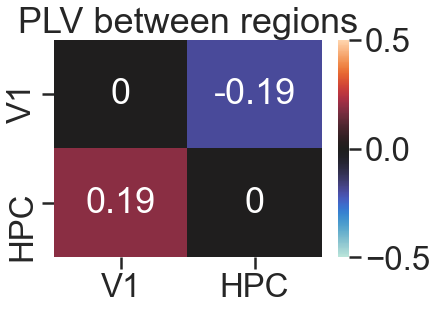

In [64]:
sns.heatmap(all_regions_PLV, 
            center=0, vmin=-0.5, vmax=0.5, annot=True,
            xticklabels=['V1','HPC'], 
            yticklabels=['V1','HPC'])
plt.title('PLV between regions')

plt.show()